In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import time
from sklearn.compose import ColumnTransformer

In [2]:
merged_data = pd.read_csv('https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true')
merged_data = merged_data.drop(['Item', 'Year'], axis = 1)
merged_data

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [3]:
# Select features (X) and target variable (y)
features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)', 'Country']
target = 'Yield (100 hg/ha)'

X = merged_data[features]
y = merged_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [4]:
# Create transformers for numeric and categorical features
numeric_features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
categorical_features = ['Country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with scaling, one-hot encoding, and Decision Tree
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': [1.0, 'sqrt', 'log2']
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', error_score='raise').fit(X_train, y_train)
# Print the best hyperparameters
print("The best hyperparameters are ", grid_search.best_params_)

The best hyperparameters are  {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


In [5]:
# Access the best estimator from the search results
best_estimator = grid_search.best_estimator_

# Training the RandomForestRegressor model using the best estimator
start_training_time = time.time()
best_estimator.fit(X_train, y_train)
end_training_time = time.time()
training_time = end_training_time - start_training_time

# Make predictions using the best estimator
start_prediction_time = time.time()
y_pred = best_estimator.predict(X_test)
end_prediction_time = time.time()
prediction_time = end_prediction_time - start_prediction_time

In [6]:
# Evaluate the model
r2 = r2_score(y_test, y_pred) # R^2
mae = mean_absolute_error(y_test, y_pred) # mean absolute error
mse = mean_squared_error(y_test, y_pred) # mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False) # root mean squared error
max_err = max_error(y_test, y_pred) # max error
mape = mean_absolute_percentage_error(y_test, y_pred) # mean absolute percentage error

print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Max Error: {max_err:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.5f} seconds")

R-squared (R2): 0.91
Mean Absolute Error (MAE): 5525.28
Mean Squared Error (MSE): 114274358.67
Root Mean Squared Error (RMSE): 10689.92
Max Error: 94998.16
Mean Absolute Percentage Error (MAPE): 0.13%
Training Time: 0.51 seconds
Prediction Time: 0.02096 seconds


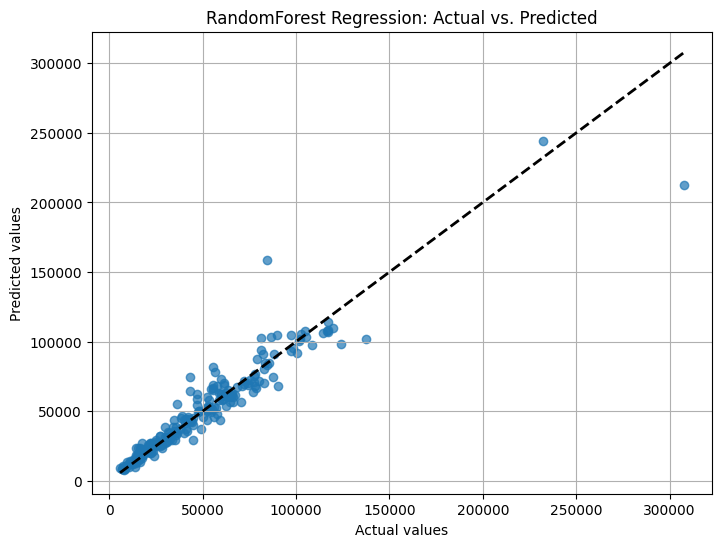

In [7]:
# Visualize predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('RandomForest Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()

In [8]:
# Get the feature names after one-hot encoding
numeric_feature_names = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_feature_names = best_estimator.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(X_train[categorical_features].columns)
all_feature_names_rf = list(numeric_feature_names) + list(categorical_feature_names)

# Get feature importance
feature_importance_rf = best_estimator.named_steps['rf'].feature_importances_

# Display the top 5 feature importance scores
print("Top 5 Feature Importances:")
for feature, importance in sorted(zip(all_feature_names_rf, feature_importance_rf), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{feature}: {importance}")

Top 5 Feature Importances:
Country_Israel: 0.1999427707281871
Fertilizer (kg/ha): 0.1806560354613155
Rainfall (mm): 0.13961982840064582
Pesticides (Tons): 0.09987099008574032
Country_Kuwait: 0.061585086009926945
